In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

# Recap previous lecture
- Principal Components Analysis (PCA)
- Eigendecomposition of a matrix
- Geometry behind PCA
- Application of PCA for:
    - Compressing the data (point cloud to line)
    - Modeling 3D Faces (3D Morphable Model  3DMM)
    - Rotating the data

# Today's lecture
## PCA with SVD
## PCA in a high dimensional space
## Application: Eigenfaces

## Eigendecompositions of Symmetric Matrices

- Hessian 
- Covariance Matrices*
- PCA*
- Kernels etc

# Eigendecompositions and Singular Value Decomposition

| Method                | $\mathbf{A}$         |  Decomposition       |
| :-------------:      |:-------------: |:-------------:
| SVD            |       any           |   $\mathbf{A}=\mathbf{U}\mathbf{\Sigma}\mathbf{V}^T$
| Eigen            |     square      |   $\mathbf{A}=\mathbf{U}\mathbf{\Sigma}\mathbf{U}^{-1}$
| Eigen            |     square/sym      | as  above but $\mathbf{U}\mathbf{U}^T=\mathbf{I}$

# Decomposition as a Geometric Pipeline

$$\mathbf{A}\mathbf{x} = \underbrace{(\mathbf{U} 
\underbrace{(\mathbf{\Sigma}\underbrace{(\mathbf{U}^{-1}\mathbf{x})}_{\text{1st step/rotate}})}_{\text{2nd step/scale and flip}})}_{\text{3rd step/rotate}}$$

| Method                | Step 1       |  Step 2       | Step 3       |
| :-------------:      |:-------------: |:-------------: |:-------------:
| geometry             |   rotate       |  scale axis        | rotate |
| SVD                  | $\mathbf{V}^T$  |  $\mathbf{\Sigma}$ | $\mathbf{U}$ | 
| geometry             |   rotate       |  scale axis        | rotate back |
| Eig                  | $\mathbf{U}^{-1}$  |  $\mathbf{\Sigma}$ | $\mathbf{U}$ | 

# Decomposition as a Geometric Pipeline

# Geometry of SVD 

Source: wikipedia
<center><img width='30%' src="https://upload.wikimedia.org/wikipedia/commons/b/bb/Singular-Value-Decomposition.svg" />

<center> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Singular_value_decomposition.gif/280px-Singular_value_decomposition.gif" />

# Principal Component Analysis (PCA)

### PCA works in unsupervised learning settings

\begin{equation}
 \underbrace{\{\mathbf{x}_i\}_{i=1}^N}_{\text{known}} \sim \underbrace{\mathcal{D}}_{\text{unknown}}
\end{equation}

### Assumptions

- $\mathbf{x}_i \in \mathbb{R}^D$ 
- $N \geq D$ (number of points higher than number of features; or else, more points than dimensions 

### Objective: find a transformation (subspace) for compressing the data

### Find projection that maximizes the spread of the data

- Find $\mathbf{u}\in \mathbb{R}^k$ $\left\|\mathbf{u}\right\|_2=1$ for which you can project the data $\mathbf{x}^{\prime}=\mathbb{P}_{\mathbf{u}}\mathbf{x}$

$$ \mathbb{P}_{\mathbf{u}}\mathbf{x} = (\mathbf{x}\mathbf{u}^T)\mathbf{u}$$

- We have to maximize the variance once projected.
- Which means making the projection of **x** with **u** **large**:
- We can measure the **size** of the projection with $\ell_2$ norm.

$$\arg\max_{\mathbf{u}} \frac{1}{N}\sum_i^N \left\|  (\mathbf{x}_i^T\mathbf{u})\mathbf{u}\right\|_2^2$$

# Full recipe
$$ \mathbf{X}^{\prime} \leftarrow \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}} $$

$$\underbrace{\mathbf{x}^{T\prime}_p}_{\text{rec}} = \underbrace{\underbrace{\mathbf{U}_{|k}}_{k \mapsto D}\quad\underbrace{\underbrace{\mathbf{U}_{|k}^T}_{D \mapsto k}\quad\underbrace{\mathbf{x}^{T\prime}}_{\text{orig}}}_{projection}}_{reconstruction}$$

$$ \mathbf{x}_p\leftarrow\left(\mathbf{x}^{T\prime}_p{\mathbf{\sigma}}\right)+\mathbf{\mu}$$

Can be use for compressing and reconstructing the data using **U** up to *k* components:
$$\underbrace{\mathbf{x}^T}_{\text{prj}} = \underbrace{\underbrace{\mathbf{U}_{|k}}_{k \mapsto D}\quad\underbrace{\underbrace{\mathbf{U}_{|k}^T}_{D \mapsto k}\quad\underbrace{\mathbf{x}^T}_{\text{orig}}}_{projection}}_{reconstruction}$$

### Alternative interpretation: Find ortogonal projection that minimize reconstruction error

$\def\mbf#1{\mathbf{#1}}$

- Find an ortogonal matrix $\mbf{U}\in \mathbb{R}^{k\times n}$ for which:


$$\arg\min_{\mbf{U}} \left\|  \mbf{X} - \mbf{U}\mbf{U}^T\mbf{X}\right\|_2^2 \\
\text{subject to} \quad \mbf{U}\mbf{U}^T = \mbf{I}
$$

- Both interpretations lead to the same results:
    - To compute $\mbf{U}$ you have to compute Eigendecomposition of covariance matrix $\mbf{X}\mbf{X}^T$

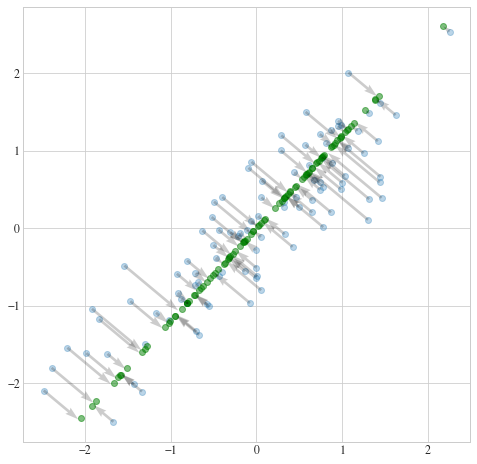

## What happens if input dimensionality is large?

- $\mbf{X} \in \mathbb{R}^{D\times N}$ then $\mathbb{Cov} = \mbf{X}\mbf{X}^T$ is a **big** matrix.
- $D \gg N$

What is the shape of $\mathbb{Cov}$?

- $\mathbb{Cov} \in \mathbb{R}^{D\times D}$.
- Eigendecomposition complexity $\mathcal{O}(D^3)$ so in our case if $D$ is large **we have a computational problem.**

# What happens in high dimension?

- We are supposed to think abou the word in a 3 dimensional?
- Our brain can think in a 3 dimensional word.
- Maybe with relativity theory we arrive into a 4-D space if we consider time also.
- So why wee need higher dimensions?

# High Dimensional Space

- Visualizing one hundred dimensional space is incredibly difficult for humans.
- Most of time the representation for an input datum is a vector in **high dimensional space.**

- You can think an image $\mathbf{I}\in \mathbb{R}^{WxH}$ as a point/vector in high dimension.
- For an image $128\times 128$ now our $D$ dimension is very high. $D=128^2=(2^7)^2=2^{14}\approx16K$

- Let's double the image $128 \mapsto 256$

- For an image $256\times 256$ now our $D$ dimension is very high. $D=256^2=(2^8)^2=2^{16}\approx65K$
- Doubling a side, increaes the dimension four times, for two-dimensional nature of images.

- So you can consider an image as a vector in $65K$ dimension!

## Let's practice with 2D real data

We will pull a 2D real dataset made of images in the wild using `sklearn`

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [3]:
faces.images[0,...].shape

(62, 47)

## Best Practice: Always look at the data before start working!

- Do not do simple summary statistics on the dataset
- Always look at a large random samples of the dataset
- The data may **contain noise** that you want to be aware of!
- Do not give for granted that the data **and** the labels are noise-free
- You could try to plot the data to lower dimension also (i.e. with PCA)

In total we have `(1348, 62, 47)` so `1348` images of dimension `62x47 = 2914`.

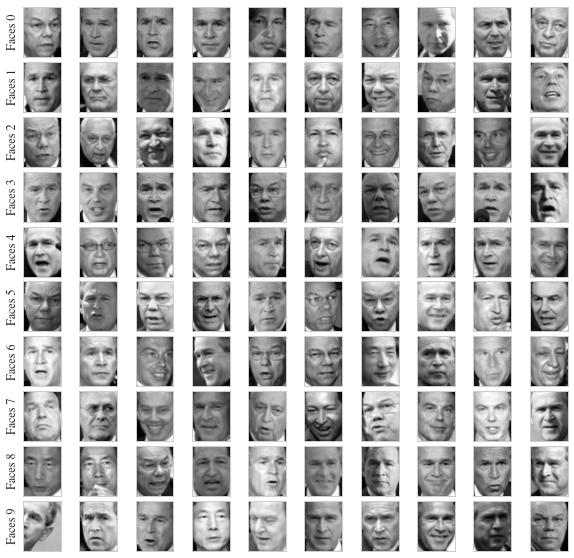

In [4]:
# Plot the faces
N_ax, N_img = 10, 10 #10 rows with 10 images per row
fig, ax = plt.subplots(N_ax, N_img,figsize=(10,10),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(N_ax):
    ax[i,0].set_ylabel(f'Faces {i}')
    for j in range(N_img):
        ax[i,j].imshow(faces.data[i*N_img+j].reshape(62, 47), cmap='gray')

## For example, what is this?

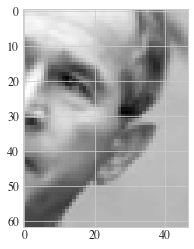

In [5]:
plt.imshow(faces.data[9*N_img].reshape(62, 47), cmap='gray')

- Looks like a misalignment error!
- This can create noise in PCA estimation

# 2D images are high dimensional vectors
- We said faces are vectors that live in a $\mathbb{[0,255]}^{2914}$, if you flatten the dimensions
- Now how many images can you drawn in this space, assuming the grayscale values are $[0,\ldots,255]$?

$$256^{H\times W}=256^{2914} \approx 10^{7018}$$

# Long Story short

- The $WxH$ where the faces live defined a **HUGE** space
- The faces samples from this space occupay a very **tiny portion** of the space
- That is, the space is very sparse given its huge "possibile" volume
- Note: the same holds for natural images (not just for faces).

## Let's random sample uniformly the space in 2914 dimensions

- This is because there is a difference between:
    1. The space where the data lives (what you see with the image)
    2. The "real" unseen space where the data may be embedded.

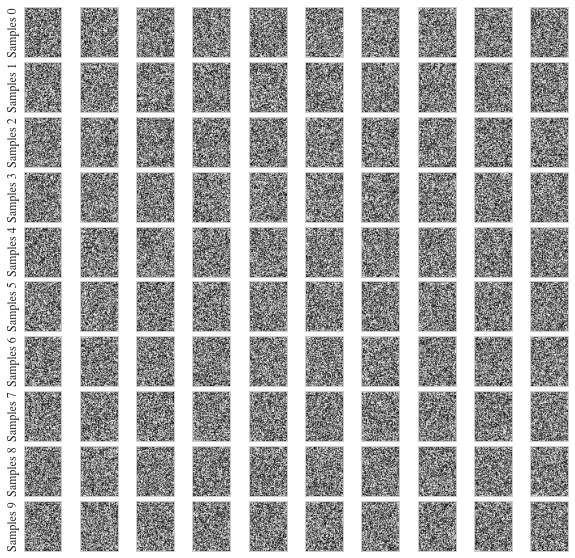

In [6]:
# Sampling
samples = np.random.uniform(0, 255, (100, 62, 47)).astype(np.uint8)
# sampling unifirmly 100 points in 62x47 space.

# Plot the faces
N_ax, N_img = 10, 10  # 10 rows with 10 images per row
fig, ax = plt.subplots(N_ax, N_img, figsize=(10, 10),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(N_ax):
    ax[i, 0].set_ylabel(f'Samples {i}')
    for j in range(N_img):
        ax[i, j].imshow(samples[i*N_img+j].reshape(62, 47), cmap='gray')

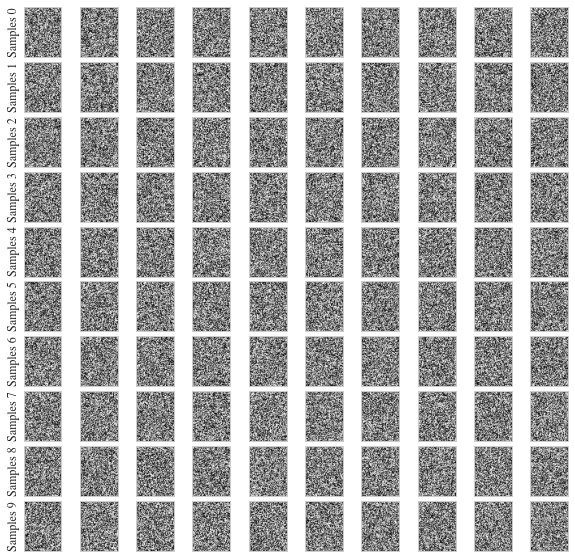

In [7]:
# Sampling
samples = np.random.uniform(0, 255, (100, 62, 47)).astype(np.uint8)
# sampling unifirmly 100 points in 62x47 space.

# Plot the faces
N_ax, N_img = 10, 10  # 10 rows with 10 images per row
fig, ax = plt.subplots(N_ax, N_img, figsize=(10, 10),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(N_ax):
    ax[i, 0].set_ylabel(f'Samples {i}')
    for j in range(N_img):
        ax[i, j].imshow(samples[i*N_img+j].reshape(62, 47), cmap='gray')

### The probability of hitting a face is very small!
The phenomenon is also know as...

# The curse of dimensionality

- Fixing the samples you have in a training set, then
- as the dimensionality grows $\rightarrow$ fewer examples in each region of the feature space

# The curse of dimensionality

- The number of training samples must **grow exponentially with dimensionality** if we want to maintain the same "density"

- This also mean [informally] that if you increase the input dimension, the number of you training samples should grow exponentially to have the same performance and **avoid "overfitting"**. 

- More on overfitting later but let's say for now that **overfitting = ML method not working well**

<img width="50%" src="https://images.deepai.org/glossary-terms/curse-of-dimensionality-61461.jpg" />

Figure Credit [DeepAI](https://deepai.org/machine-learning-glossary-and-terms/curse-of-dimensionality)

# Ambient space
{{_=plt.imshow(faces.data[0*N_img].reshape(62, 47), cmap='gray')}}

# Embedded space

$$\underbrace{\mathbf{I}}_{\text{what you see}} = \mathcal{G}(\text{id}, \text{pose}, \text{age}, \text{etnicity}, \text{illumination})$$

Face may be "living" in a lower embedded space defined by:
  1. Identity
  2. Pose
  3. Age
  4. Etnicity etc.

# Stranger things happen in higher dimensions

<img align='right' width='30%' src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Stranger_Things_logo.png/640px-Stranger_Things_logo.png" />


- As **D** increases, the volume of the hypersphere goes to zero while hyper-cube keeps constant.
- Training samples may be located the the corners of the hypercube.

<img width='60%' src="https://www.visiondummy.com/wp-content/uploads/2014/04/sparseness.png" />

Credit [Vincent Spruyt](https://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/)



<img width='70%' src=attachment:hyper-cube.png
     />
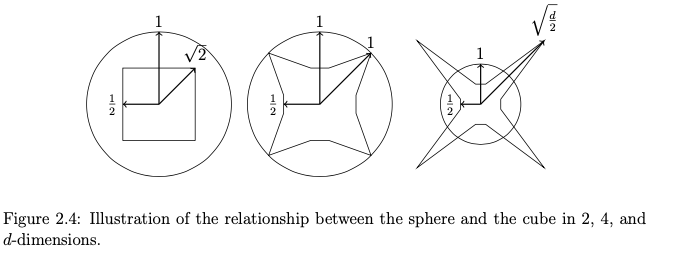


<img width='40%' src=attachment:image.png
     />
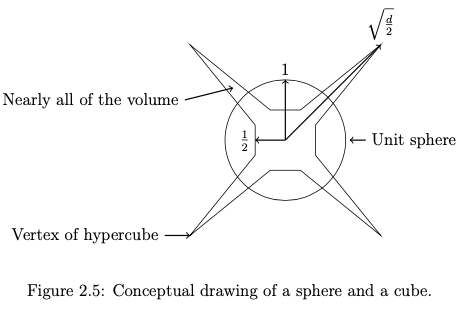

### Distances in high dimensional space

Distances in high dimension follow a pattern:

- Distance of points sampled on the unit sphere goes to zero as D increases.
- Euclidean distance of points goes to $4\sqrt{D}$.
- The variance of distances between two random points keeps shrinking as D increases.

<img width='50%' src="figs/distribution_distances.png" />

[Figure Credit from this paper](https://openaccess.thecvf.com/content_ICCV_2017/papers/Zhang_Learning_Spread-Out_Local_ICCV_2017_paper.pdf)

[See this chapter for more explanations](http://ciml.info/dl/v0_99/ciml-v0_99-ch03.pdf)

## Dimensionality in ML: some reference numbers
- `D ≈ 20` is considered “low dimensional,” 
- `D ≈ 1,000` is “medium dimensional”
- `D ≈ 100,000` is “high dimensional”.

# Eigenfaces (i.e. PCA applied to 2D images)

In [8]:
from sklearn.decomposition import PCA 

In [9]:
pca = PCA(n_components=150) # retain 150 components
print(faces.data.shape) #NxD N=1348 samples in ~3K-D space
pca.fit(faces.data)

(1348, 2914)


PCA(n_components=150)

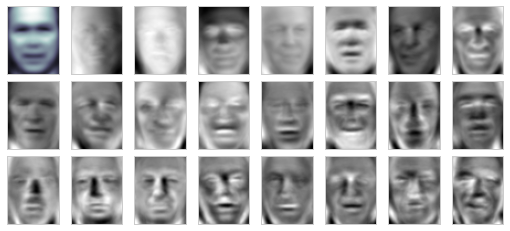

In [10]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.imshow(pca.mean_.reshape(62, 47), cmap='bone') #  plot mean
    else:
        ax.imshow(pca.components_[i].reshape(62, 47), cmap='gray') # plots components

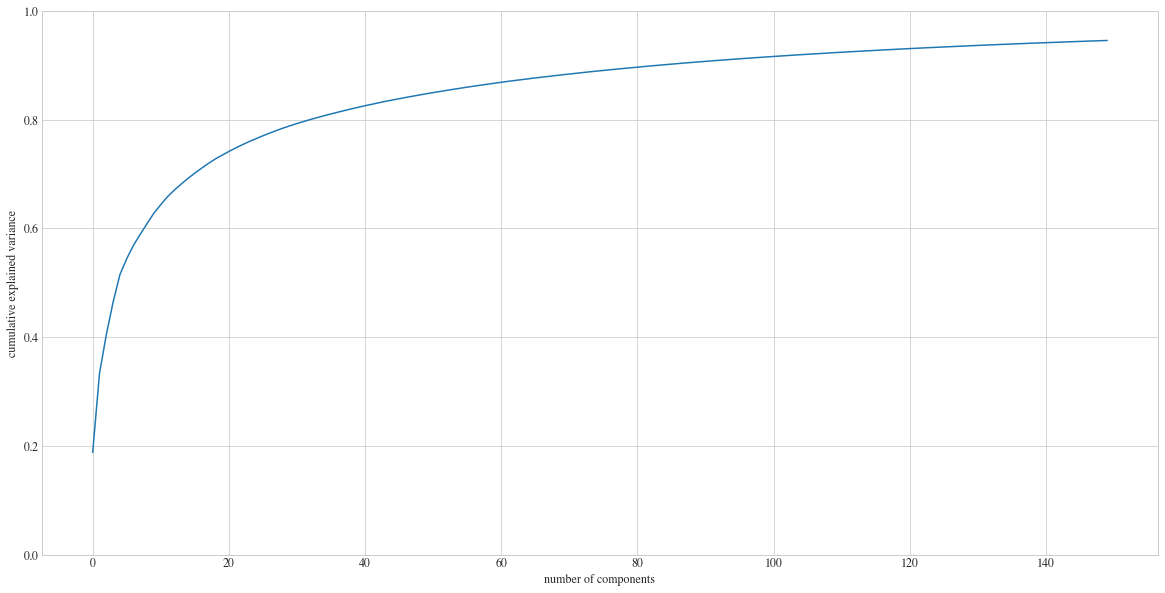

In [11]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
_ = plt.ylim([0,1])

# Subspaces in decreasing order of variance

$$ (\lambda_1,\mathbf{u}_1),\ldots,(\lambda_d,\mathbf{u}_d) = \text{eig}(\mathbf{X}^T\mathbf{X}) $$

<ins>Note: *numpy is not guaranteed to return it ordered so you have to sort*</ins>

## How do we choose the subspace where to cut the dimension?
- From $D$-dimensional to $k$-dimension
- Given the spectrum $$\mathbf{\Sigma} = \text{diag}(\lambda_1,...,\lambda_d)$$ we can remove the dimension considering the spectrum "energy" and retain e.g. 95% of the variance in data.

That is , Keep k components until:

$$\frac{\sum_i^k \lambda_i}{\sum_i^d \lambda_i} \leq 95\%$$

#  Data compression

- **The first 150 components explain more than 90% of data!**
- From $2914$ space to $150$ space with **no loss of information?** 
- Let's project back to the input space and see.

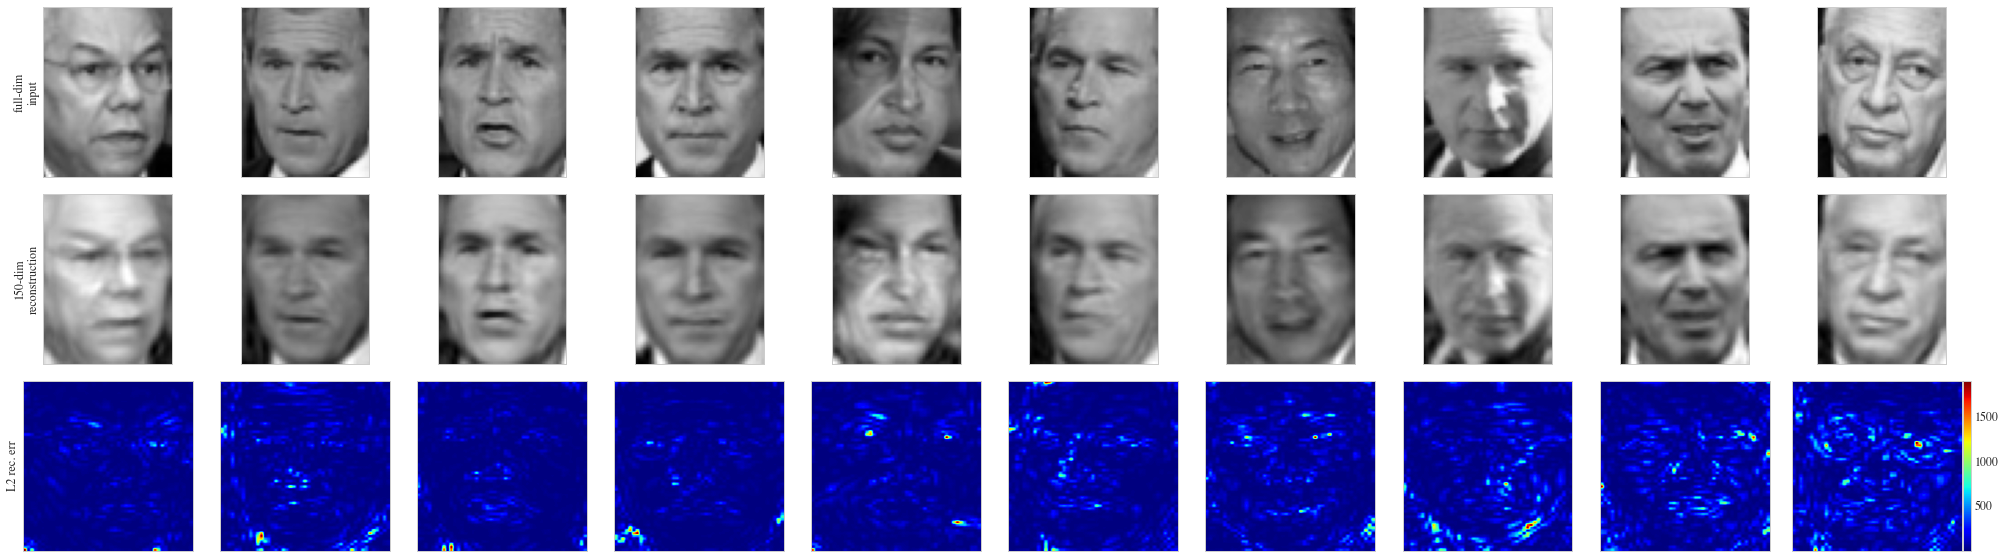

In [12]:
plt.rcParams['axes.grid'] = False
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# Project back to the input
# Project back to the input
projected = pca.transform(faces.data) # project with P = U_t*X_t
unprojected = pca.inverse_transform(projected) # unproject with U*P = U(U_t*X_t)
# Now plot
fig, ax = plt.subplots(3, 10, figsize=(35, 10),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

# it is important to get the max value of the error so that
# we plot heatmap error with the SAME SCALE!
errors_img = [(unprojected[i]-faces.data[i])**2 for i in range(10)]
max_val = max([err.max() for err in errors_img])

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='gray')
    ax[1, i].imshow(unprojected[i].reshape(62, 47), cmap='gray')
    erri = ax[2, i].imshow((errors_img[i]).reshape(
        62, 47), cmap='jet', extent=[0, max_val]*2)
    if i == 9:
        divider = make_axes_locatable(ax[2, i])
        cax = divider.append_axes("right", size="5%", pad=0.005)
        plt.colorbar(erri, cax=cax)

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction')
_ = ax[2, 0].set_ylabel('L2 rec. err')

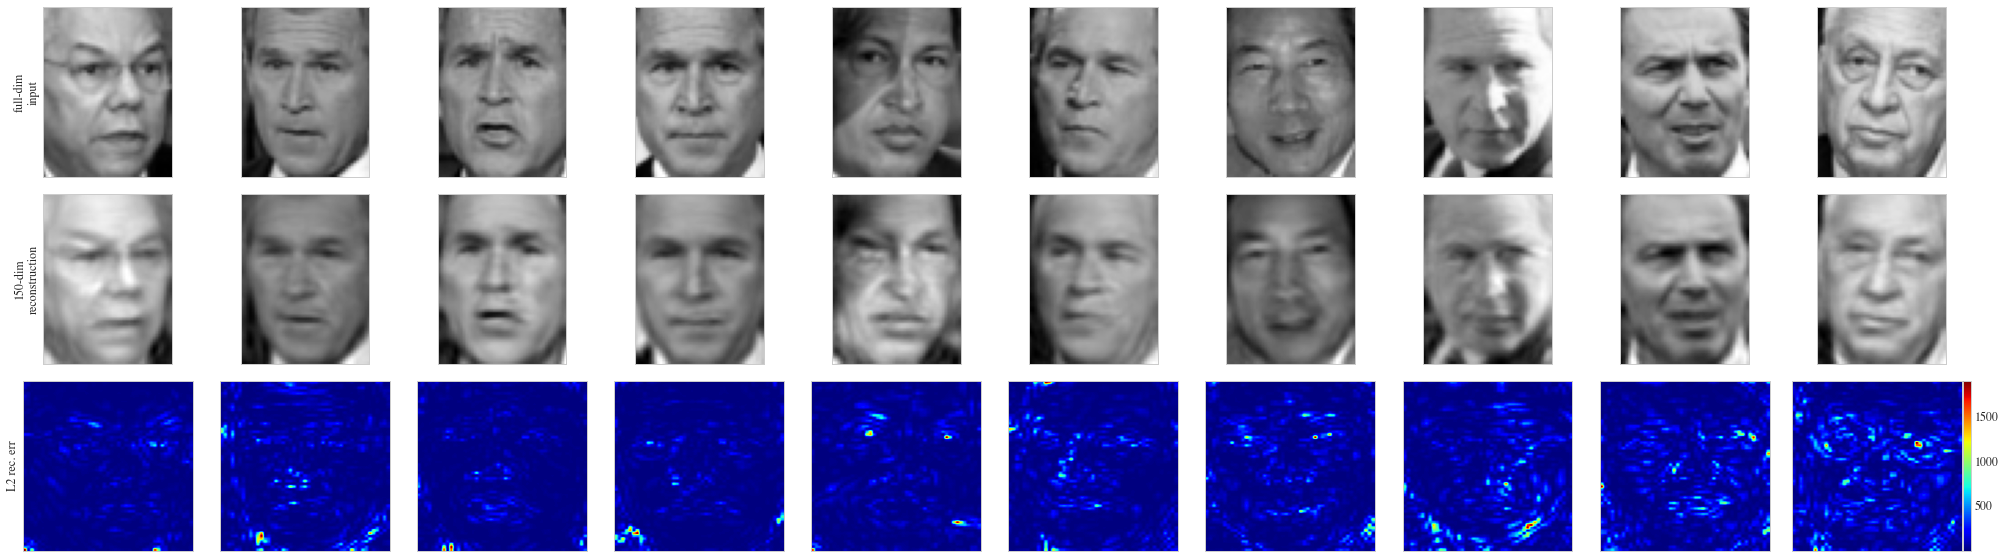

In [13]:
plt.rcParams['axes.grid'] = False
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# Project back to the input
# Project back to the input
projected = pca.transform(faces.data) # project with P = U_t*X_t
unprojected = pca.inverse_transform(projected) # unproject with U*P = U(U_t*X_t)
# Now plot
fig, ax = plt.subplots(3, 10, figsize=(35, 10),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

# it is important to get the max value of the error so that
# we plot heatmap error with the SAME SCALE!
errors_img = [(unprojected[i]-faces.data[i])**2 for i in range(10)]
max_val = max([err.max() for err in errors_img])

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='gray')
    ax[1, i].imshow(unprojected[i].reshape(62, 47), cmap='gray')
    erri = ax[2, i].imshow((errors_img[i]).reshape(
        62, 47), cmap='jet', extent=[0, max_val]*2)
    if i == 9:
        divider = make_axes_locatable(ax[2, i])
        cax = divider.append_axes("right", size="5%", pad=0.005)
        plt.colorbar(erri, cax=cax)

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction')
_ = ax[2, 0].set_ylabel('L2 rec. err')

## Let's try with only 3 Components!

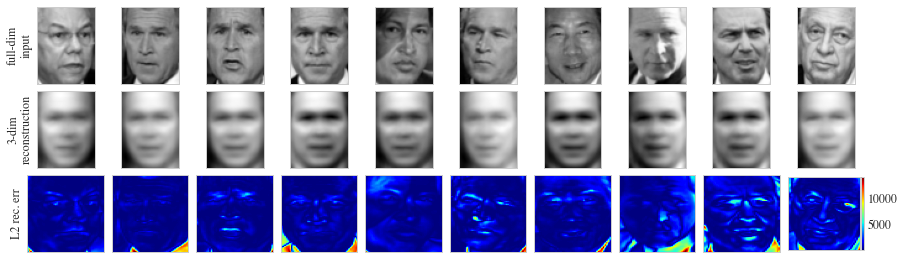

In [14]:
############### Fittin with 3 component ######
pca = PCA(n_components=3) # retain 3 components
pca.fit(faces.data)
#############################################
##### Plot
# Project back to the input
projected = pca.transform(faces.data) # project with P = U_t*X_t
unprojected = pca.inverse_transform(projected) # unproject with U*P = U(U_t*X_t)
# Now plot
fig, ax = plt.subplots(3, 10, figsize=(15, 4.5),
                       subplot_kw={'xticks': [], 'yticks': []},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

# it is important to get the max value of the error so that
# we plot heatmap error with the SAME SCALE!
errors_img = [(unprojected[i]-faces.data[i])**2 for i in range(10)]
max_val = max([err.max() for err in errors_img])

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='gray')
    ax[1, i].imshow(unprojected[i].reshape(62, 47), cmap='gray')
    erri = ax[2, i].imshow((errors_img[i]).reshape(
        62, 47), cmap='jet', extent=[0, max_val]*2)
    if i == 9:
        divider = make_axes_locatable(ax[2, i])
        cax = divider.append_axes("right", size="5%", pad=0.005)
        plt.colorbar(erri, cax=cax)

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('3-dim\nreconstruction')
_ = ax[2, 0].set_ylabel('L2 rec. err')

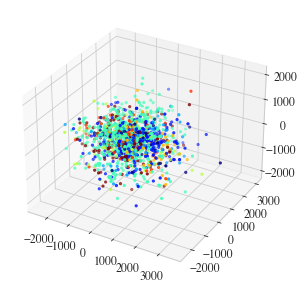

In [15]:
# Nx3
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
_ = ax.scatter(*projected.T, c=faces.target, marker='.', cmap='jet')

## Color maps to Identity
### Looks like not a great projection for separating the identity!
### At the end makes sense since PCA is unsupervised method.

## Now I will show you some data and then you need to tell me if using
## PCA is a good way to separate the color of the data

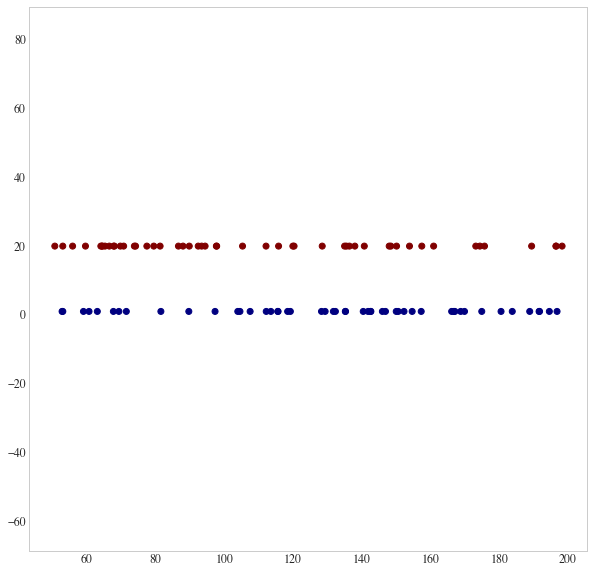

In [16]:
plt.figure(figsize=(10,10))
np.random.seed(0)
N_samples = 50
# samples points for class 1
X_1 = np.random.uniform(50, 200, N_samples)
X_1 = np.vstack((X_1, (1,)*N_samples))
# samples points for class 2
X_2 = np.random.uniform(50, 200, N_samples)
X_2 = np.vstack((X_2, (20,)*N_samples))
X = np.concatenate((X_1, X_2))
# data
X = np.concatenate((X_1, X_2), axis=1)
# labels
labels = X[1, ...]
# Plot also the training points
plt.scatter(
    x=X[0, ...],
    y=X[1, ...],
    c=labels,
    cmap='jet',
)
# Code below wants Nx2
X = X.T
_ = plt.axis('equal')

# Why compression

This example is just usef for illustrative purpose since **Machine Learning** is much related to **Information Theory**.

<img width="50%" src="figs/compression_net.png" />

# How to apply PCA 

# Usage of  PCA

- **Inductive** (estimate basis on training set); apply on test set - **Most common**
- **Transductive** (get all the points at test time; estimate and project) - **Assumes you have all the points at test-time**

## Inductive Settings
Most of methods covered in this course are **"Inductive"** (as opposed to **transductive**).

- Inductive works well for **supervised methods** but can also applied to **unsupervised methods.**
- **[Training]** Estimate $\mbf{U}$ on a training set (and also mean $\mu$ and std $\sigma$)
- **[Test Time]** Given a new point $\mbf{x}^{\prime}$ at test-time, apply PCA, that is project $\mbf{x}^{\prime}$ with $\mbf{U}, \mu, \sigma$

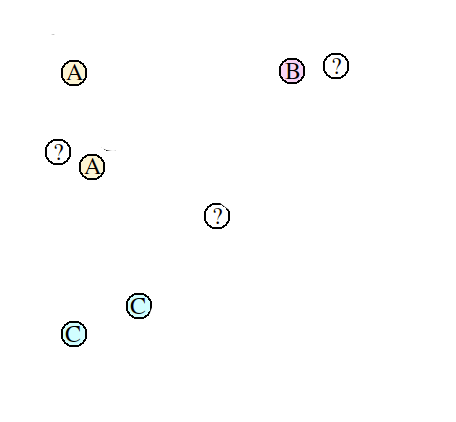


## On the side: Transductive Settings

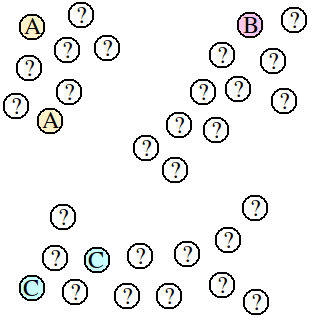


[Vapnik'98 - Learning by Transduction](https://arxiv.org/ftp/arxiv/papers/1301/1301.7375.pdf)

# Artificial Intelligence and Machine Learning <a class="tocSkip">


## Unit II <a class="tocSkip">


**Iacopo Masi**


March 17, 2022

# Tracking of Attendance to cope with COVID-19

Token prodigit for this lecture:
## `423310`

Please use this code to make your presence on prodigit

https://prodigit.uniroma1.it/


The code for the building is:
## 	`AULA 3 -- CU028-E01P01L001`

# Any question of previous lectures before moving on?

- We will review a few concept of PCA at the end of matrix calculus

# Matrix Calculus

Part of this lectures are taken from:

- [CS229 LinAlg](http://cs229.stanford.edu/summer2019/cs229-linalg.pdf)
- [CS229 Calculus Recap](https://www.youtube.com/watch?v=b0HvwszmqcQ)
- [Dive Into Deep Learning - Math Appendix](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/single-variable-calculus.html)

# Basic example: scalar to scalar

- **Function:** $f:\mathbb{R} \mapsto\mathbb{R}$
- **Example:** $f(x) = x^2$ 
- **Value taken (output):** scalar $\mathbb{R}$ 
- **First Derivative:** $f(x)^{\prime}$: $2x\in\mathbb{R}$
- **Second Derivative:** $f(x)^{\prime\prime}$: $2\in\mathbb{R}$       

# Vector to scalar

- **Function:** $f:\mathbb{R}^d \mapsto\mathbb{R}$
- **Example:** Loss or cost function
- **Value taken (output):** scalar $\mathbb{R}$ 
- **First Derivative:** $f(x)^{\prime}$: $\mathbb{R}^d$ **Gradient**
- **Second Derivative:** $f(x)^{\prime\prime}$: $\mathbb{R}^{d\times d}$ **Hessian** - Square and Symmetric Matrix

# Vector to vector

- **Function:** $f:\mathbb{R}^d \mapsto\mathbb{R}^p$
- **Example:** projection / neural network layer / classifier input vector to 1...N classes
- **Value taken (output):** vector $\mathbb{R}^p$ 
- **First Derivative:** $f(x)^{\prime}$: $\mathbb{R}^{d\times p}$ **Jacobian**
- **Second Derivative:** $f(x)^{\prime\prime}$: $\mathbb{R}^{d\times p \times p}$ **Tensor of second derivative** (high order tensor)
<br/><br/>

- Informally: a **tensor** is generalization of matrix in N-D dimensions
 - Ex: if you stack N `256x256` images you get `Nx256x256` which is a tensor.

# Why Calculus?


- Let's take a complex function $$f(x) = \sin(x^x)$$ over the $[0, 3]$. 
- Its behaviour is not simple to understand.

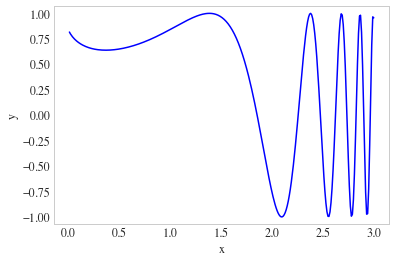

In [17]:
x_big = np.arange(0.01, 3.01, 0.01)
ys = np.sin(x_big**x_big)
_ = plt.plot(x_big, ys, 'b-')
plt.xlabel('x');plt.ylabel('y');
_ = plt.axis('equal')

- At this large scale, the function’s behavior is not simple. 
- However, if we **reduce our range to something smaller like**  $[1.75, 2.25]$ , we see that the graph becomes much simpler.
- You can think as if we are zooming into a small part of it

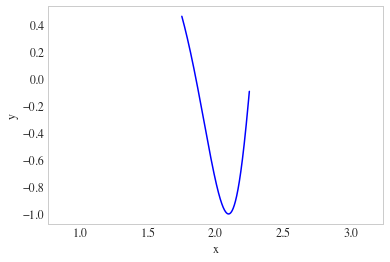

In [18]:
x_med = np.arange(1.75, 2.25, 0.001)
ys = np.sin(x_med**x_med)
_ = plt.plot(x_med, ys, 'b-')
plt.xlabel('x');plt.ylabel('y');
_ = plt.axis('equal')

Taking this to an extreme, if we zoom into a **tiny segment**, the behavior becomes far simpler: **it is just a straight line.**

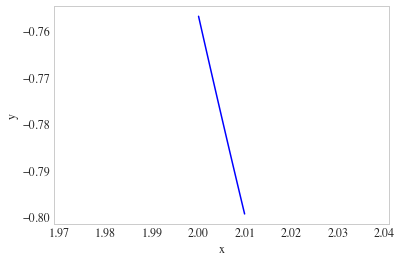

In [19]:
x_small = np.arange(2.0, 2.01, 0.0001)
ys = np.sin(x_small**x_small)
_ = plt.plot(x_small, ys, 'b-')
plt.xlabel('x');plt.ylabel('y');
_ = plt.axis('equal')

- This is the key observation of single variable calculus: **the behavior of familiar functions can be modeled by a line in a small enough range.**  

- This means that for most functions, it is reasonable to expect that as **we shift the $x$ value of the function by a little bit**, the **output $f(x)$ will also be shifted** by a little bit.

- The only question we need to answer is, _"How large is the change in the output compared to the change in the input?  Is it half as large?  Twice as large?"_

Thus, we can consider the ratio of the change in the output of a function for a small change in the input of the function.  We can write this formally as

$$
\frac{L(x+\epsilon) - L(x)}{(x+\epsilon) - x} = \frac{L(x+\epsilon) - L(x)}{\epsilon}.
$$

$$\frac{df}{dx}(x) = \lim_{\epsilon \rightarrow 0}\frac{f(x+\epsilon) - f(x)}{\epsilon}.$$

Different texts will use different notations for the derivative. For instance, all of the below notations indicate the same thing:

$$
\frac{df}{dx} = \frac{d}{dx}f = f' = \nabla_xf = D_xf = f_x.
$$

## Finite Difference

- Take a value $\mbf{x}$ and see how the function $f(\mbf{x}+\epsilon)$ changes in the neighborhood of that values under small pertburation $\epsilon$.

- Is this a good method?

- NO! Super slow, there is no optimization.

### Linear Approximation

When working with derivatives, it is often useful to geometrically interpret the approximation used above.  In particular, note that the equation 

$$
f(x+\epsilon) \approx f(x) + \epsilon \frac{df}{dx}(x),
$$

### Linear Approximation
Approximates the value of $f$ by:
- a line which passes through the point $(x, f(x))$
- has slope $\frac{df}{dx}(x)$

in a neighbourood $[-\epsilon,+\epsilon]$

In this way we say that the derivative gives a linear approximation to the function $f$, as illustrated below:

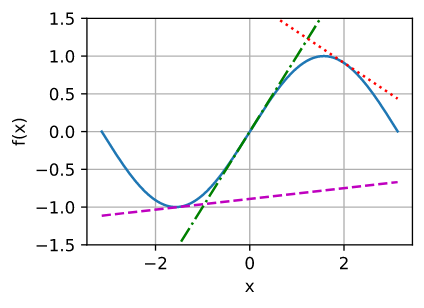

# Gradient

$\def\der#1#2{\frac{\partial #1}{\partial #2}}$
$\def\derr#1#2#3{\frac{\partial^2 #1}{\partial#2\partial #3}}$

- **Function:** $f:\mathbb{R}^d \mapsto\mathbb{R}$

$$\nabla_{\mbf{x}}f(\mbf{x}) = \nabla_{\mbf{x}}f\left([x_1,\ldots,x_d]\right) = \left[\der{f\left(\mbf{x}\right)}{x_1},...,\der{f\left(\mbf{x}\right)}{x_d} \right]^T$$

- Geometric Interpretation
    - **Direction of steepest ascent**.
    - The direction to change the input so that the function values goes up in $[x,x+\epsilon]$
    
    $$f\Big(\mbf{x} + \epsilon\nabla_{\mbf{x}}f(\mbf{x})\Big) \ge f(\mbf{x})$$
    - Gradient can be defined for matricies too not only vector $\nabla_{\mbf{X}}f(\mbf{X})$
    - Just think the matrix as a long, stretched vector

<img width="70%" src="figs/gradients.png" />

[Figure credit](https://people.csail.mit.edu/jsolomon/share/book/numerical_book.pdf)

<img width='30%' src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Gradient2.svg/1920px-Gradient2.svg.png" />

The gradient, represented by the blue arrows, denotes the **direction of greatest change of a scalar function**. The values of the function are represented in **greyscale and increase in value from white (low) to dark (high)**.

Figure credit Wikipedia

## Try it yourself - Gradient of dot product

Given the function $f(\mbf{x};\mbf{b})= \mbf{b}^T\mbf{x}$ parametrized by the vector $\mbf{b}$ that takes as input a vector $\mbf{x}$---both vectors in $\mbf{x}^d$---compute the gradient of x $$\nabla_\mbf{x} f(\mbf{x}) = \nabla_\mbf{x} \mbf{b}^T\mbf{x}$$

# Hessian

- **Function:** $f:\mathbb{R}^d \mapsto\mathbb{R}$

$$\nabla^2_{\mbf{x}}f(\mbf{x}) = \nabla^2_{\mbf{x}}f\left([x_1,\ldots,x_d]\right) =
\begin{bmatrix}
\derr{f\left(\mbf{x}\right)}{x_1}{x_1} & \ldots & \derr{f\left(\mbf{x}\right)}{x_1}{x_d} \\
\ldots &      & \ldots \\
\derr{f\left(\mbf{x}\right)}{x_d}{x_1} & \ldots & \derr{f\left(\mbf{x}\right)}{x_d}{x_d} \\
\end{bmatrix}
$$

- Geometric Interpretation
    - **Indicates the curvature of the function** (can tell you if you are close to local minimum/maximum or saddle point)
    - Can be interpreted as the **Jacobian matrix of the gradient of the function**
    - Symmetric and Square


# Quadratic Forms


Given $\mbf{A} \in \mathbb{R}^{d\times d}$ symmetric and square and $\mbf{x} \in \mathbb{R}^d$ then a quadratic form is:
$$\mbf{x}^T \mbf{A}\mbf{x}$$

- It is vector to scalar function
- It used for characterizing **Definiteness** of matrices

# Definiteness and relation with Eigenvalues

- $\forall \mbf{x} \neq 0 \qquad \mbf{x}^T \mbf{A}\mbf{x} \gt 0 $ is **positive definite (PD)** - Relation with eigenvalues all positve
- $\forall \mbf{x} \neq 0 \qquad \mbf{x}^T \mbf{A}\mbf{x} \ge 0 $ is **positive semi-definite (PSD)** - Relation with eigenvalues all non-negative
- $\forall \mbf{x} \neq 0 \qquad \mbf{x}^T \mbf{A}\mbf{x} \lt 0 $ is **negative definite (ND)** - Relation with eigenvalues all negative
- $\forall \mbf{x} \neq 0 \qquad \mbf{x}^T \mbf{A}\mbf{x} \le 0 $ is **negative semi-definite (NSD)** - Relation with eigenvalues all non-positive

- $\forall \mbf{x} \neq 0 \qquad \mbf{x}^T \mbf{A}\mbf{x} \lt, \gt 0 $ is **indefinite** - Relation with eigenvalues mixed in sign

<img width='70%' src="figs/definitiviness.png" />

### Common Derivatives

* **Derivative of constants.** $\frac{d}{dx}c = 0$.
* **Derivative of linear functions.** $\frac{d}{dx}(ax) = a$.
* **Power rule.** $\frac{d}{dx}x^n = nx^{n-1}$.
* **Derivative of exponentials.** $\frac{d}{dx}e^x = e^x$.
* **Derivative of the logarithm.** $\frac{d}{dx}\log(x) = \frac{1}{x}$.

### Derivative Rules

- **Important: Derivation is a linear operator.**
1. Derivative of the sum is the sum of derivatives
2. Derivative of a scalar product is the scalar product of derivative.

* **Sum rule.** $\qquad\nabla_{\mbf{x}} \left( g(\mbf{x}) + h(\mbf{x}) \right) = \nabla_{\mbf{x}}g(\mbf{x}) + \nabla_{\mbf{x}}h(\mbf{x})  $
* **Product rule.** $\qquad\nabla_{\mbf{x}} \left(g(\mbf{x})\cdot h(\mbf{x})\right) = \nabla_{\mbf{x}}[g(\mbf{x})]h(\mbf{x}) + \nabla_{\mbf{x}}[h(\mbf{x})]g(\mbf{x})$
* **Chain rule.** $\qquad\nabla_{\mbf{x}} g(h(\mbf{x})) = \nabla_{h(\mbf{x})} [g(h(\mbf{x}))]\cdot\nabla_{\mbf{x}}h(\mbf{x})\qquad$ **Very important for Deep Learning**

## Try it yourself

Compute $\nabla_{\mbf{x}}\mbf{x}^T\mbf{A}\mbf{x}$.

Can be seen as $\mbf{x}^T\mbf{f(x)}$ where $\mbf{f(x)} = \mbf{A}\mbf{x}$